In [8]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
from sklearn.cluster import KMeans

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import matplotlib.cm as cm
#import plotly
import plotly.graph_objects as go
#import plotly_express as px
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score, silhouette_score, homogeneity_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import scale

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist, cdist

## Loading Dataset

In [18]:
file=pd.read_csv('Ping and Perf v2.csv')
file=file.drop(['Application Category', 'Label' ],axis=1)
file.head()
#file=np.array(file)
#y_train=file['Application Category']
file

,Inter-Arrival Time (in sec),RLC_DL size,MCS,NB_RB
0,0.000000,44,12.00,4.00
1,0.034998,21,12.00,4.00
2,0.031017,8,12.00,4.00
3,0.015997,8,12.00,4.00
4,0.027990,135,12.00,4.00
5,1.001450,86,12.00,4.00
6,1.001449,86,12.00,4.00
7,1.000992,86,12.00,4.00
8,1.001911,86,12.00,4.00
9,1.001148,86,12.00,4.00


In [27]:
X_train, y_train = file[0], file[1]
X_validation, y_validation = file[0], file[1]
X_test, y_test = file[0], file[1]

train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)



# Inertia/ Elbow point


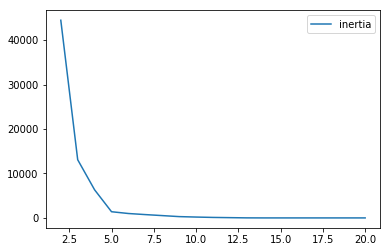

In [4]:
# K-means - Inertia as the number of clusters varies
kMeans_inertia=pd.DataFrame(data=[], index=range(1,10), columns=['inertia'])
for n_clusters in range(2,21):
    kmeans=KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=0.0001, n_jobs=2)
    kmeans.fit(file)
    kMeans_inertia.loc[n_clusters]=kmeans.inertia_
kMeans_inertia.plot()

## Accuracy of the clustering

In [39]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [40]:
# K-means - Accuracy as the number of clusters varies
#n_clusters = 3
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    
    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

ValueError: Length mismatch: Expected axis has 5 elements, new values have 2 elements

In [31]:
#MY CODE

n_clusters = 3
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

y_train=pd.DataFrame(data=file, index=range(0,len(file)))
kMeans_inertia= pd.DataFrame(data=[], index=range(2,21), columns=['inertia'])
overallAccuracy_KMeansDF=pd.DataFrame(data=[], index=range(2,21), columns=['Overall Accuracy'])
for n_clusters in range(2,21):
    kmeans=KMeans(n_clusters=n_clusters, n_init=10, max_iter=300,tol=0.0001, random_state=2018, n_jobs=2)
    kmeans.fit(file)
    kMeans_inertia.loc[n_clusters]=kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(file)
    X_train_kmeansClustered= pd.DataFrame(X_train_kmeansClustered, index=file.index, columns=['cluster'])
    countByCluster_kMeans, countByLabel_kMeans,countMostFreq_kMeans, accuracyDF_kMeans,overallAccuracy_kMeans,accuracyByLabel_kMeans=analyzeCluster(X_train_kmeansClustered, y_train)
    overallAccuracy_kMeansDF.loc[n_clusters]=overallAccuracy_kMeans
overallAccuracy_kMeansDF.plot()

ValueError: Length mismatch: Expected axis has 5 elements, new values have 2 elements

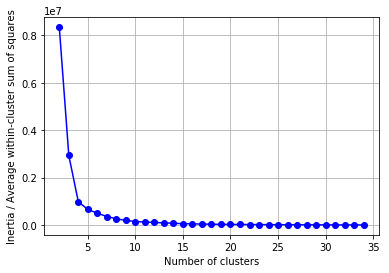

In [13]:
file=pd.read_csv('Final Randomized Dataset v2.csv')
file=file.drop(['Application Category '],axis=1)

inertias=[]
for i in range(2,35):
    km=KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300)
    km.fit(file)
    inertias.append(km.inertia_)
plt.plot(range(2,35), inertias,'b*-', marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Average within-cluster sum of squares')
plt.show()

In [16]:
kmeans=KMeans(n_clusters=3).fit(file)
labels=kmeans.labels_
print(kmeans.labels_)
# computing coordinates of cluster centroids
array3=kmeans.cluster_centers_
array3


[0 0 0 ... 0 0 0]


array([[4.94455667e-03, 8.01956989e+02, 1.91733306e+01, 1.03904817e+01],
       [5.78875085e-01, 7.31275862e+01, 1.71314138e+01, 7.46931034e+00],
       [1.16315256e-02, 6.13890411e+02, 1.85604110e+01, 7.87123288e+00],
       [1.39334694e-02, 3.31705263e+02, 1.88333684e+01, 8.27315789e+00]])

# Silhouette Score

In [7]:
for k in range(2,21):
    k_means_fitk=KMeans(n_clusters=k)
    k_means_fitk.fit(file)
    print("for K Value", k, "Silhouette Score: %0.3f" % silhouette_score(file, k_means_fitk.labels_, metric='euclidean'))

for K Value 2 Silhouette Score: 0.987
for K Value 3 Silhouette Score: 0.920
for K Value 4 Silhouette Score: 0.938
for K Value 5 Silhouette Score: 0.961
for K Value 6 Silhouette Score: 0.956
for K Value 7 Silhouette Score: 0.967
for K Value 8 Silhouette Score: 0.957
for K Value 9 Silhouette Score: 0.952
for K Value 10 Silhouette Score: 0.962
for K Value 11 Silhouette Score: 0.964
for K Value 12 Silhouette Score: 0.957
for K Value 13 Silhouette Score: 0.954
for K Value 14 Silhouette Score: 0.957
for K Value 15 Silhouette Score: 0.945
for K Value 16 Silhouette Score: 0.924
for K Value 17 Silhouette Score: 0.918
for K Value 18 Silhouette Score: 0.906
for K Value 19 Silhouette Score: 0.909
for K Value 20 Silhouette Score: 0.897


Number of cluster--> 3/4

# ELBOW POINT- Statistical approach


Text(0,0.5,'Average within-cluster sum of squares')

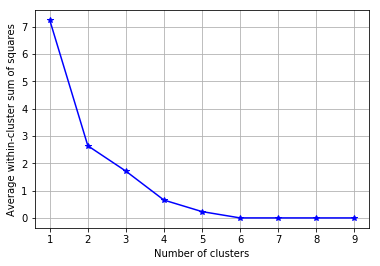

In [221]:

#Average within-cluster sum of squares
K=range(1,10)
KM= [KMeans(n_clusters=k).fit(file) for k in K]
centroids= [k.cluster_centers_ for k in KM]
D_k=[cdist(file, centrds, 'euclidean') for centrds in centroids]
cIdx=[np.argmin(D, axis=1) for D in D_k]
dist=[np.min(D, axis=1) for D in D_k]
avgWithinSS=[sum(d)/ file.shape[0] for d in dist]

# Total within cluster sum of squares
wcss= [sum(d**2) for d in dist]
tss= sum(pdist (file**2)/ file.shape[0])
bss=tss-wcss

#elbow curve- Avf within cluster sum of squares
fig= plt.figure()
ax=fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel ('Average within-cluster sum of squares')

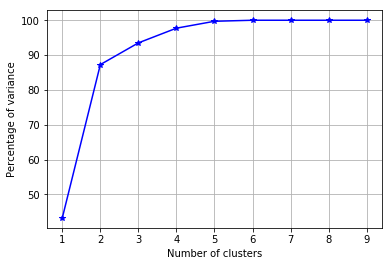

In [222]:
# elbow curve- percentage of variance
fig= plt.figure()
ax= fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance')
plt.show()

## Silhouette Coefficient Graphs- denoting the width of each cluster and the cluster assignments

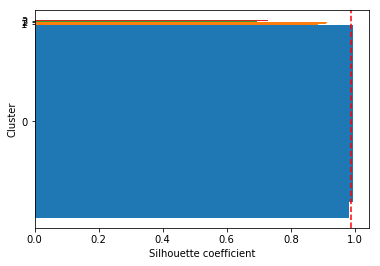

In [14]:
km=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300,tol=0.0001, random_state=0)
y_km=km.fit_predict(file)
cluster_labels= np.unique(y_km)
n_clusters=cluster_labels.shape[0]
silhouette_vals=silhouette_samples(file, y_km, metric='euclidean')
y_ax_lower, y_ax_upper=0,0
yticks=[]
for i, c in enumerate(cluster_labels):
    c_silhouette_vals= silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper+=len(c_silhouette_vals)
    #color=cm.jet(i/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),c_silhouette_vals, height=1.0, edgecolor='none')
    yticks.append((y_ax_lower+y_ax_upper)/2)
    y_ax_lower+=len(c_silhouette_vals)
silhouette_avg=np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks,cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()
    

/Users/kuhuhalder/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


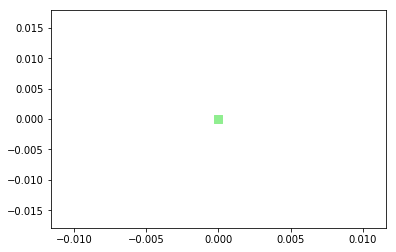

In [37]:
km=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=0)
y_km=km.fit_predict(file)
plt.scatter(y_km==[0,0], y_km==[0,1], s=50, c='lightgreen', marker='s', label='cluster 1')
plt.scatter()


In [171]:
#file=file.drop(['NB_RB'],axis=1)
#data=py.data.file()
#plotly.tools.set_credentials_file(username='KuhuHalder', api_key='DFwxyyPyEWUzN4MOHop3')

#fig=py.scatter_3d(file, x='Inter-Arrival Time', y='Packet size', z='MCS')

TypeError: scatter() missing 1 required positional argument: 'ys'

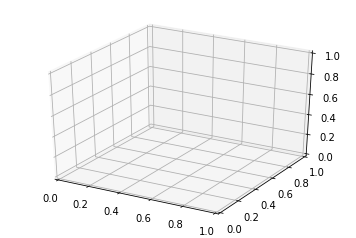

In [192]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
Axes3D.scatter(file['Inter-Arrival Time (in sec)'],file['Packet Size'],zs=file['MCS'], zdir='z', s=20, c=None)
ax.show()

In [272]:
file.head()

,Inter-Arrival Time (in sec),Packet Size,MCS,NB_RB
0,0.000000,44,12,4
1,0.034998,21,12,4
2,0.031017,8,12,4
3,0.015997,8,12,4
4,0.027990,135,12,4


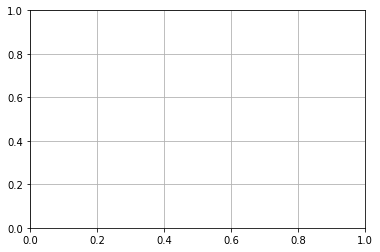

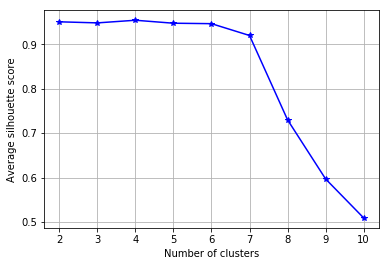

In [300]:
from sklearn.metrics import silhouette_score
nb_clusters=[2,3,4,5,6,7,8,9,10]
avg_silhouette=[]
for n in nb_clusters:
    km=KMeans(n_clusters=n)
    Y=km.fit_predict(file)
    avg_silhouette.append(silhouette_score(file,Y, metric='euclidean'))
plt.grid(True)
fig= plt.figure()
ax=fig.add_subplot(111)
plt.grid(True)
ax.plot(nb_clusters, avg_silhouette, 'b*-')
plt.title('')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.show()


## Confusion Matrix- computing the accuracy of the KMeans model/ fit

In [10]:
x_data= file.drop(['Application Category','Label'], axis=1)
y_data= file['Application Category']
k_means_fit=KMeans(n_clusters=3, max_iter=300)
k_means_fit.fit(x_data)
print("\n KMeans Clustering Algorithm- Confusion Matrix \n\n", pd.crosstab(y_data, k_means_fit.labels_, rownames=['Actual'], colnames=['Predicted']))
print("\nSilhouette Score: %0.3f"% silhouette_score(x_data, k_means_fit.labels_, metric='euclidean'))





 KMeans Clustering Algorithm- Confusion Matrix 

 Predicted         0   1   2
Actual                     
Control Signals  15   0   5
PERF              0  76   0
PING              0   0  69

Silhouette Score: 0.920


In [8]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
iris=datasets.load_iris()
x=scale(iris.data)
y=pd.DataFrame(iris.target)


array([[-9.00681170e-01,  1.01900435e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00, -1.31979479e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.38535265e+00,  3.28414053e-01, -1.39706395e+00,
        -1.31544430e+00],
       [-1.50652052e+00,  9.82172869e-02, -1.28338910e+00,
        -1.31544430e+00],
       [-1.02184904e+00,  1.24920112e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-5.37177559e-01,  1.93979142e+00, -1.16971425e+00,
        -1.05217993e+00],
       [-1.50652052e+00,  7.88807586e-01, -1.34022653e+00,
        -1.18381211e+00],
       [-1.02184904e+00,  7.88807586e-01, -1.28338910e+00,
        -1.31544430e+00],
       [-1.74885626e+00, -3.62176246e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00,  9.82172869e-02, -1.28338910e+00,
        -1.44707648e+00],
       [-5.37177559e-01,  1.47939788e+00, -1.28338910e+00,
        -1.31544430e+00],
       [-1.26418478e+00,  7.88807586e-01, -1.22655167e+00,
      